<a href="https://colab.research.google.com/github/ksemina61/task1semestr/blob/main/sem05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Сначала тут идет семинар, листайте вниз, там как раз 2 задания домашних.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Стекинг

Использовать стекинг в sklearn очень просто:

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X, y = load_iris(return_X_y=True)

# Create Base Learners
base_learners = [
                 ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)), # estimator - кол-во деревьев, которые мы учим
                 ('rf_2', KNeighborsClassifier(n_neighbors=5))
                ]

# Initialize Stacking Classifier with the Meta Learner
clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

# Extract score
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
clf.fit(X_train, y_train).score(X_test, y_test)

0.9473684210526315

# Беггинг. Random Forest

Мотивацию построения алгоритма случайного леса (Random Forest) удобно рассматривать в терминах смещения и дисперсии. Начнём с построения решающего дерева.

In [ ]:
!pip install mlxtend==0.22.0 # библиотека для визуализации деревьев

In [ ]:
# Пример отсюда: http://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/

from sklearn.model_selection import train_test_split
from mlxtend.data import boston_housing_data

X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    shuffle = True)

Shuffle - это параметр в функции train_test_split, который определяет, будут ли перемешаны данные перед разделением на обучающий и тестовый наборы.

Если shuffle=True, то данные будут перемешаны перед разделением, что помогает избежать возможных искажений или зависимостей, которые могут быть связаны с порядком данных в исходном наборе.

Если shuffle=False, то данные будут разделены без предварительного перемешивания.

В бэггинге, включая случайный лес (Random Forest), часто используется перемешивание данных для создания различных обучающих поднаборов для каждого дерева или модели, чтобы повысить разнообразие и уменьшить переобучение.

In [ ]:
from sklearn.tree import DecisionTreeRegressor # деревья решения
from sklearn.metrics import mean_squared_error

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print('MSE train:', mean_squared_error(y_train, y_pred_train))
print('MSE test:', mean_squared_error(y_test, y_pred_test))
# Алгоритм переобучился, на трейне ошибка отличается сильно от теста

MSE train: 0.0
MSE test: 11.153627450980393


In [ ]:
from mlxtend.evaluate import bias_variance_decomp

_, bias, variance = bias_variance_decomp(dt, X_train, y_train, X_test, y_test, loss = 'mse') # раскладывает ошибку получившегося алгоритма

In [ ]:
bias

8.464116026960784

In [ ]:
variance

11.914841325980392

Как мы обсуждали на предыдущем семинаре, такое дерево окажется сильно переобученным (высокая дисперсия и низкое смещение). Постараемся исправить это. На лекции мы обсуждали, что один из способов борьбы с переобучением – построение композиций моделей. На этом семинаре мы рассмотрим построение композиций при помощи бэггинга.

#### Бэггинг

Вспомним суть алгоритма:

1. Обучаем много деревьев на бутстрапированных подвыборках исходной выборки независимо друг от друга. Бутстрапированную подвыборку строим при помощи выбора $N$ (размер исходной выборки) наблюдений из исходной выборки с возвращением.

2. Усредняем предсказания всех моделей (например, берём арифметическое среднее).

Можно показать, что модель, построенная при помощи бэггинга, будет иметь **то же смещение**, что и у отдельных деревьев, но значительно **меньшую дисперсию** (при выполнении некоторых условий).

In [ ]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

base_tree = DecisionTreeRegressor(random_state=42)

bagging = BaggingRegressor(base_tree, n_estimators=20)
bagging.fit(X_train, y_train)

_, bias, variance = bias_variance_decomp(bagging, X_train, y_train, X_test, y_test, loss='mse')
bias, variance
# Дисперсия уменьшает вес, беггринг на вес не влияет

(9.23271628513481, 2.6436741903553926)

Как мы видим, по сравнению с единичным деревом смещение практически не изменилось, но дисперсия уменьшилась в несколько раз!

Посмотрим, как это отразилось на среднеквадратичной ошибке.

In [ ]:
ypred_test = bagging.predict(X_test)
ypred_train = bagging.predict(X_train)
print(mean_squared_error(y_train, ypred_train), mean_squared_error(y_test, ypred_test))

7.254728960396042 14.12159093137255


#### Случайный лес

При построении каждого дерева в бэггинге в ходе создания очередного узла будем выбирать случайный набор признаков, на основе которых производится разбиение. В результате такой процедуры мы уменьшим корреляцию между деревьями, за счёт чего снизим дисперсию итоговой модели. Такой алгоритм назвывается **случайным лесом** (Random Forest).

По сравнению с единичным деревом к параметрам случайного леса добавляются:
- `max_features` – число признаков, на основе которых проводятся разбиения при построении дерева.

- `n_estimators` – число деревьев.

Естественно, все параметры, относящиеся к единичному дереву, сохраняются для случайного леса.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=20, random_state=42)

_, bias, variance = bias_variance_decomp(rf, X_train, y_train, X_test, y_test, loss = 'mse')
print(bias, variance)

ypred_test = rf.predict(X_test)
ypred_train = rf.predict(X_train)
print(mean_squared_error(y_train, ypred_train), mean_squared_error(y_test, ypred_test))
# Дисперсия уменьшилась, качество 7.9 улучшилось
# out of bag поможет оценить и подобрать деревья

9.624094608670339 2.7309115371629904
7.949923205445546 17.51088774509804


#### OOB Error

Как мы обсудили выше, при построении случайного леса каждое дерево строится на бутстрапированной подвыборке, полученной из исходной обучающей выборки случайным набором с повторениями. Понятно, что некоторые наблюдения попадут в такую подвыборку несколько раз, а некоторые не войдут в неё вообще. Для каждого дерева можем рассмотреть объекты, которые не участвовали в обучении и использовать их для валидации.

Усреднённая ошибка на неотобранных образцах по всему случайному лесу называется **out-of-bag-ошибкой**.

In [ ]:
X, y = boston_housing_data()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 123,
                                                    shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# oob_score_ = R2 на не виденных наблюдениях
rf = RandomForestRegressor(n_estimators = 100, random_state = 123, oob_score = True, n_jobs=-1)
rf.fit(X_train, y_train)
rf.oob_score_
#

0.8760889947613861

n_jobs=-1 - параметр, который используется в некоторых алгоритмах машинного обучения для указания количества параллельных задач, которые должны выполняться. Значение -1 указывает на то, что все доступные ядра процессора будут использоваться для выполнения задач параллельно. Это может ускорить процесс обучения модели, особенно при обработке больших данных.

oob_score_ - это параметр, который используется в методе "out-of-bag" для оценки качества модели случайного леса. Он указывает, следует ли использовать out-of-bag ошибку для вычисления оценки качества модели. Out-of-bag ошибка - это ошибка, которая вычисляется на тех образцах, которые не участвовали в обучении данного дерева решений.

In [ ]:
pred = rf.predict(X_test)

from sklearn.metrics import r2_score

r2_score(y_test, pred)
# качество на r2, если тут плохое качество а на oob - хороший, значит модель переобучилась

0.8253137316695912

# Бустинг

In [ ]:
!pip install xgboost
!pip install catboost
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.3 MB/s eta 0:00:00


## <font color='blue'>XGBoost</font> eXtreme Gradient Boosting

### https://github.com/dmlc/xgboost

### Пример

Возьмем датасет Boston Housing и обучим XGBoost на нем.

In [ ]:
import xgboost as xgb

xgb.__version__

'2.0.3'

In [ ]:
!wget https://raw.githubusercontent.com/rsuh-python/mag2022/main/CL/term02/04-ClassificationTrees/Boston.csv

--2024-03-14 10:36:33--  https://raw.githubusercontent.com/rsuh-python/mag2022/main/CL/term02/04-ClassificationTrees/Boston.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36137 (35K) [text/plain]
Saving to: ‘Boston.csv’

Boston.csv          100%[===================>]  35.29K  --.-KB/s    in 0.001s  

2024-03-14 10:36:33 (42.9 MB/s) - ‘Boston.csv’ saved [36137/36137]



In [ ]:
from xgboost import XGBClassifier, XGBRegressor
import warnings

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, mean_squared_error


rng = np.random.RandomState(31337)

data = pd.read_csv('Boston.csv')
X = data.drop('medv', axis=1)
y = data.medv

kf = KFold(n_splits=2, shuffle=True, random_state=rng) #kFold - кросс-валидация

np.random.RandomState - это класс из библиотеки NumPy, который нужен для генерации случайных чисел с фиксированным seed (зерном). Установка seed позволяет воспроизводить результаты случайных операций.

KFold - это метод кросс-валидации, который разбивает набор данных на K равных частей (фолдов) и проводит обучение и тестирование модели K раз, каждый раз используя разные части данных в качестве тестового набора. Это позволяет снизить вероятность переобучения и улучшить оценку качества модели. Кроме того, кросс-валидация позволяет получить более устойчивую и объективную оценку качества модели.

XGBoost предлагает 2 способа использования алгоритмов:
* sklearn-совместимые классы XGBClassifier, XGBRegressor

* "оригинальная" python-библиотека

###  sklearn

In [ ]:
# Обучение моедли
for fold_index, (train_index, test_index) in enumerate(kf.split(X)): # разделил выборку на две части
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("RMSE on fold {}: {}".format(fold_index, np.sqrt(mean_squared_error(actuals, predictions))))

RMSE on fold 0: 3.5812710660839144
RMSE on fold 1: 4.418517453314897


### xgboost python

In [ ]:
def get_params():
    params = {}
    params["objective"] = "reg:squarederror"
    params["booster"] = "gbtree"
    params["eval_metric"] = "rmse"
    params["max_depth"] = 3 # ограничиваю деревья до 3
    params["tree_method"] = "approx"
    params["sketch_eps"] = 1

    return params

for fold_index, (train_index, test_index) in enumerate(kf.split(X)):

    params = get_params()

    xgtrain = xgb.DMatrix(X[train_index], label=y[train_index]) #собираю X и y в одну матрицу (X_train, y_train)
    xgtest = xgb.DMatrix(X[test_index], label=y[test_index])

    bst = xgb.train(params, xgtrain) #аналог fit в sklearn

    print("RMSE on fold {}: {}".format(fold_index, bst.eval(xgtest)))
# xgboost умеет работать с пропусками, не умеет обрабатывать категориальные признаки

RMSE on fold 0: [0]	eval-rmse:3.47391334157689924
RMSE on fold 1: [0]	eval-rmse:4.04864032163758303


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:46:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sketch_eps" } are not used.

  warnings.warn(smsg, UserWarning)


#### Пропуски в данных

XGBoost умеет обрабатывать разреженные матрицы

Но категориальные признаки нужно приводить к числовому виду

Нужно указать, какое число является "пропуском"

При сплите, алгоритм смотрит в какую сторону лучше отвести объекты с пропуском.

In [ ]:
xgtrain_missed = xgb.DMatrix(X[test_index], label=y[test_index], missing=-999.0)

xgb.DMatrix - это класс из библиотеки XGBoost, который представляет данные для обучения модели.

В данном случае, xgb.DMatrix используется для создания матрицы данных из тестового набора X[test_index] с соответствующими целевыми значениями y[test_index].

Параметр missing=-999.0 указывает на то, что значение -999.0 в данных считается отсутствующим (missed или missing value).

#### Feature importances

Подсчитывает, сколько раз каждый признак использовался для использовался в вершине дерева при разбиении

Это не качество фактора, а его важность

In [ ]:
bst.get_fscore() # оценка важности признаков

{'f0': 6.0,
 'f1': 1.0,
 'f4': 9.0,
 'f5': 14.0,
 'f6': 1.0,
 'f7': 6.0,
 'f9': 5.0,
 'f10': 4.0,
 'f11': 5.0,
 'f12': 18.0}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1200x1200 with 0 Axes>

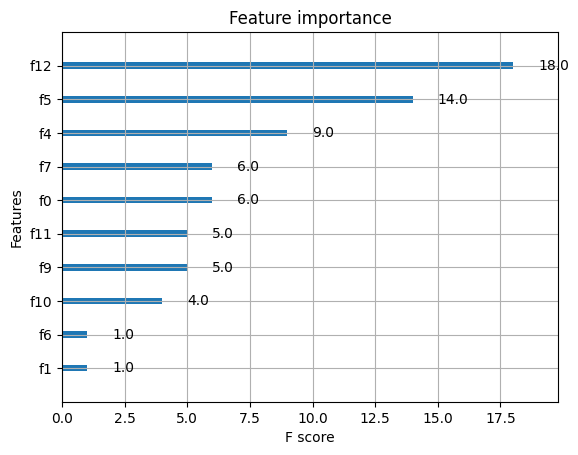

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))
xgb.plot_importance(bst) # умеет изображать важности признаков

## LightGBM. Пример решения задачи.

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import warnings

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100,
                                        random_state=241)

Обучение

In [ ]:
print('Starting training...')
# train
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1') # метрика оценки качества


Starting training...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 406, number of used features: 13
[LightGBM] [Info] Start training from score 22.746305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

LGBMRegressor(learning_rate=0.05, n_estimators=20)

Предсказание и оценка качества

In [ ]:
print('Starting predicting...')

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_) # когда предскажем на тесте, потом увидем ошибку

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

Starting predicting...
The rmse of prediction is: 5.259625962258064
Feature importances: [35, 0, 6, 0, 20, 70, 21, 31, 3, 7, 15, 4, 83]


Можно задать любую метрику качества - надо написать свою функцию.

In [ ]:
# self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False


print('Starting training with custom eval function...')
# train
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=rmsle)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmsle of prediction is:', rmsle(y_test, y_pred)[1])

Starting training with custom eval function...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1030
[LightGBM] [Info] Number of data points in the train set: 406, number of used features: 13
[LightGBM] [Info] Start training from score 22.746305
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

Подбор гиперпараметров.

In [ ]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 270, number of used features: 12
[LightGBM] [Info] Start training from score 22.805926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Предсказание и оценка качества

In [ ]:
pred = gbm.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, pred)

12.703535974721541

## CatBoost

In [ ]:
import catboost
print(catboost.__version__)

1.2.3


Считываем данные

In [ ]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets # у него есть свой собственный датасет

https://www.kaggle.com/c/amazon-employee-access-challenge/data

In [ ]:
(train_df, test_df) = catboost.datasets.amazon()

In [ ]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Подготовка данных

In [ ]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1) # целевая переменная

In [ ]:
cat_features = list(range(0, X.shape[1])) # смотрим признаки
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [ ]:
print('Labels: {}'.format(set(y))) # смотрим значения y
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


In [ ]:
dataset_dir = './amazon'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# We will be able to work with files with/without header and
# with different separators.
train_df.to_csv(
    os.path.join(dataset_dir, 'train.tsv'),
    index=False, sep='\t', header=False
)
test_df.to_csv(
    os.path.join(dataset_dir, 'test.tsv'),
    index=False, sep='\t', header=False
)

train_df.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
)
test_df.to_csv(
    os.path.join(dataset_dir, 'test.csv'),
    index=False, sep=',', header=True
)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

Обучение

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,          # гиперпараметры
    learning_rate=0.1,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


Печать результатов обучения

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=150,
#     verbose=5, - уровень многословности
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose = 3
)

Learning rate set to 0.162066
0:	learn: 0.5765572	test: 0.5766422	best: 0.5766422 (0)	total: 32.4ms	remaining: 4.83s
3:	learn: 0.3828682	test: 0.3830266	best: 0.3830266 (3)	total: 116ms	remaining: 4.22s
6:	learn: 0.2952615	test: 0.2952535	best: 0.2952535 (6)	total: 161ms	remaining: 3.28s
9:	learn: 0.2478728	test: 0.2483678	best: 0.2483678 (9)	total: 251ms	remaining: 3.51s
12:	learn: 0.2193492	test: 0.2180675	best: 0.2180675 (12)	total: 330ms	remaining: 3.47s
15:	learn: 0.2007458	test: 0.1970088	best: 0.1970088 (15)	total: 420ms	remaining: 3.52s
18:	learn: 0.1901703	test: 0.1840867	best: 0.1840867 (18)	total: 520ms	remaining: 3.59s
21:	learn: 0.1836267	test: 0.1763071	best: 0.1763071 (21)	total: 616ms	remaining: 3.59s
24:	learn: 0.1806816	test: 0.1726814	best: 0.1726814 (24)	total: 698ms	remaining: 3.49s
27:	learn: 0.1770253	test: 0.1689148	best: 0.1689148 (27)	total: 820ms	remaining: 3.57s
30:	learn: 0.1750605	test: 0.1659663	best: 0.1659663 (30)	total: 921ms	remaining: 3.54s
33:	learn

Вычисление метрик

In [ ]:
from matplotlib import pylab as plt

from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)

Наилучшее количество деревьев

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100, # выберет кол-во деревьев, которые не переобучается, если качесство на тесте растет,значит нужно перестать обучать модель
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)

In [ ]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 82


Кросс-валидация

In [ ]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False
)

Training on fold [0/5]

bestTest = 0.1695893693
bestIteration = 38

Training on fold [1/5]

bestTest = 0.164632916
bestIteration = 48

Training on fold [2/5]

bestTest = 0.15425211
bestIteration = 35

Training on fold [3/5]

bestTest = 0.1433537051
bestIteration = 55

Training on fold [4/5]

bestTest = 0.1560519524
bestIteration = 55



In [ ]:
cv_data.head() # возвращает датафрейм

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.302367,0.004317,0.302196,0.004517,0.513577,0.030360
1,1,0.227370,0.007679,0.228497,0.005126,0.642263,0.048004
2,2,0.190856,0.006917,0.196796,0.003999,0.791709,0.011361
3,3,0.178884,0.007455,0.186682,0.003242,0.813889,0.009362
4,4,0.172286,0.007957,0.181380,0.002135,0.826529,0.005319


In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1582±0.0102 on step 53


In [ ]:
cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    inverted=False,
    shuffle=True,
    partition_random_seed=0,
    stratified=True,
    verbose=False
)

best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Training on fold [0/5]

bestTest = 0.1614486451
bestIteration = 31

Training on fold [1/5]

bestTest = 0.1551886688
bestIteration = 56

Training on fold [2/5]

bestTest = 0.1597838545
bestIteration = 25

Training on fold [3/5]

bestTest = 0.1523066165
bestIteration = 56

Training on fold [4/5]

bestTest = 0.1577738401
bestIteration = 30

Best validation Logloss score, stratified: 0.1580±0.0041 on step 56


Детектор переобучения

In [ ]:
model_with_early_stop = CatBoostClassifier(
    iterations=200, # сколько деревьев мы обучили на ошибках
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)

In [ ]:
print(model_with_early_stop.tree_count_)

30


In [ ]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)

In [ ]:
print(model_with_early_stop.tree_count_)

30


Выбор порога

In [ ]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False
)

In [ ]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

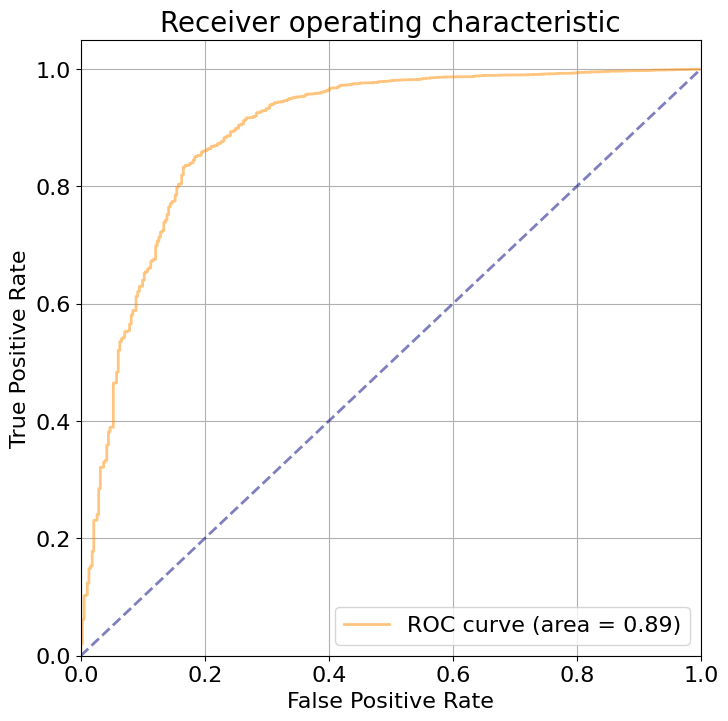

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

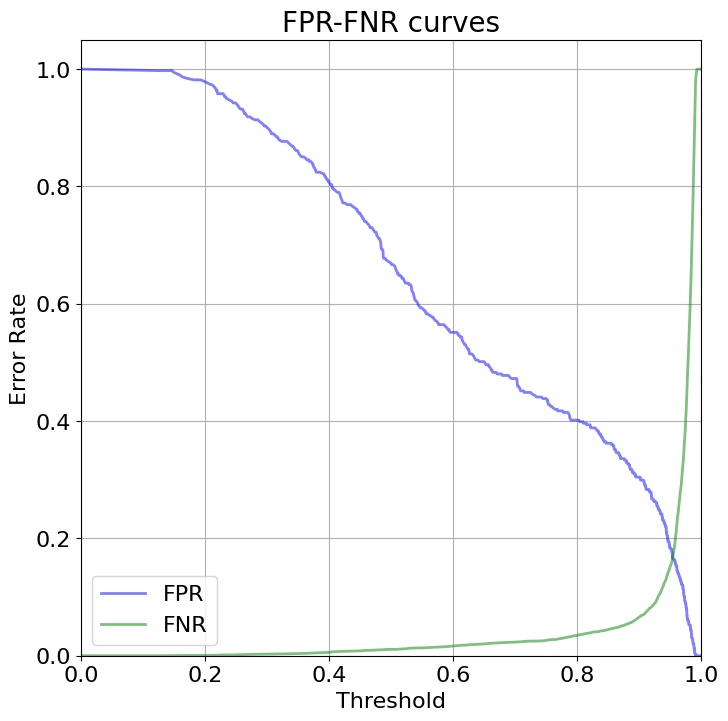

In [ ]:
plt.figure(figsize=(8, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.4805444481363058
0.9900857295557712


Предсказания модели

In [ ]:
print(model.predict_proba(X_validation))

[[0.0597 0.9403]
 [0.014  0.986 ]
 [0.0132 0.9868]
 ...
 [0.0163 0.9837]
 [0.0203 0.9797]
 [0.0332 0.9668]]


In [ ]:
print(model.predict(X_validation))

[1 1 1 ... 1 1 1]


In [ ]:
raw_pred = model.predict(
    data=X_validation,
    prediction_type='RawFormulaVal'
)
print(raw_pred)

[2.756  4.2541 4.312  ... 4.1022 3.8753 3.3723]


In [ ]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probabilities = sigmoid(raw_pred)

print(probabilities)

[0.9403 0.986  0.9868 ... 0.9837 0.9797 0.9668]


Последовательные предсказания

In [ ]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0,
    ntree_end=5,
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.4791 0.5209]
 [0.4791 0.5209]
 [0.4791 0.5209]
 ...
 [0.4791 0.5209]
 [0.4791 0.5209]
 [0.4791 0.5209]]
Iteration 1, predictions:
[[0.4581 0.5419]
 [0.4581 0.5419]
 [0.4581 0.5419]
 ...
 [0.4581 0.5419]
 [0.4581 0.5419]
 [0.4581 0.5419]]
Iteration 2, predictions:
[[0.4381 0.5619]
 [0.4381 0.5619]
 [0.4381 0.5619]
 ...
 [0.4381 0.5619]
 [0.4381 0.5619]
 [0.4381 0.5619]]
Iteration 3, predictions:
[[0.4185 0.5815]
 [0.4185 0.5815]
 [0.4185 0.5815]
 ...
 [0.4185 0.5815]
 [0.4185 0.5815]
 [0.4185 0.5815]]
Iteration 4, predictions:
[[0.398  0.602 ]
 [0.4044 0.5956]
 [0.4044 0.5956]
 ...
 [0.398  0.602 ]
 [0.398  0.602 ]
 [0.4044 0.5956]]


Многоклассовая классификация

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=50,
    random_seed=43,
    loss_function='MultiClass'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)

Важность признаков

In [ ]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,MGR_ID,31.659932
1,RESOURCE,17.171955
2,ROLE_FAMILY_DESC,12.332457
3,ROLE_DEPTNAME,10.864216
4,ROLE_CODE,8.994698
5,ROLE_ROLLUP_2,8.847865
6,ROLE_ROLLUP_1,5.537394
7,ROLE_TITLE,2.484312
8,ROLE_FAMILY,2.107171


Сохранение модели

In [ ]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

In [ ]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0


#### Настройка гиперпараметров

Скорость обучения

In [ ]:
from catboost import CatBoost
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False
)

Точность

In [ ]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton'
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation)
)

# Задание

Решите задачу с данными train_small.csv, test_small.csv с помощью CatBoost, xgboost и LightGBM. Найдите оптимальные параметры. Сравните скорость обучения и качество.

Начну последовательное решение этой задачи с помощью Бустинга. Для начала рассмотрю XGboost. Сначала установлю его сюда.

In [ ]:
!pip install xgboost
#!pip install catboost
#!pip install lightgbm

In [ ]:
import xgboost as xgb
xgb.__version__

'2.0.3'

In [ ]:
import pandas as pd
df = pd.read_csv('train_small.csv')
df.head()

,Unnamed: 0,Existing_EMI,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,Interest_Rate_Missing,...,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2,Disbursed
0,8161,0.0,250000.0,5.0,23200,2,3,28,1,1,...,0,0,0,0,0,1,0,1,0,0.0
1,77530,0.0,0.0,0.0,25000,0,0,33,1,1,...,0,0,0,1,0,1,1,0,0,0.0
2,80633,0.0,0.0,0.0,95000,3,7,39,1,1,...,0,0,0,1,0,1,1,0,0,0.0
3,45059,0.0,0.0,0.0,29880,5,3,28,0,0,...,0,0,0,0,0,1,0,1,0,0.0
4,54857,4500.0,100000.0,3.0,30000,5,10,26,0,0,...,0,0,0,1,0,1,1,0,0,0.0


In [ ]:
df = pd.read_csv('test_small.csv')
df.head()

,Unnamed: 0,Existing_EMI,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,Interest_Rate_Missing,...,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2,Disbursed
0,35478,0.0,300000.0,5.0,34000,3,10,32,0,0,...,0,0,0,0,0,1,0,1,0,1.0
1,68483,0.0,160000.0,0.0,23000,7,0,31,1,1,...,0,0,0,1,1,0,1,0,0,0.0
2,74927,0.0,200000.0,4.0,13000,4,1,27,0,0,...,0,0,0,1,0,1,1,0,0,0.0
3,83034,5000.0,500000.0,5.0,50000,5,16,29,0,0,...,0,0,0,1,0,1,1,0,0,0.0
4,82929,9000.0,300000.0,0.0,28500,4,8,30,0,0,...,0,0,0,1,0,1,1,0,0,0.0


In [ ]:
X_train = pd.read_csv('train_small.csv')
X_test = pd.read_csv('test_small.csv')
ytrain = X_train['Disbursed']
Xtrain = X_train.copy()
del Xtrain['Disbursed']
ytest = X_test['Disbursed']
Xtest = X_test.copy()
del Xtest['Disbursed']

In [ ]:
from xgboost import XGBClassifier, XGBRegressor
import warnings
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, mean_squared_error
rng = np.random.RandomState(31337)
y_train = X_train['Disbursed']
X_train = X_train.drop('Disbursed', axis=1)
y_test = X_test['Disbursed']
X_test = X_test.drop('Disbursed', axis=1)
kf = KFold(n_splits=2, shuffle=True, random_state=rng) #kFold - кросс-валидация

XgBoost предлагает 2 способа использования алгоритмов. Сделаю через sklearn-совместимые классы XGBClassifier, XGBRegressor.



Нужно изменить X[train_index] и y[train_index] на X_train.iloc[train_index] и y_train.iloc[train_index], так как исходные данные у меня представлены как X_train и y_train.

In [ ]:
# Обучение моедли
for fold_index, (train_index, test_index) in enumerate(kf.split(X_train)): # разделил выборку на две части
  xgb_model = xgb.XGBRegressor()
  xgb_model.fit(X_train.iloc[train_index], y_train.iloc[train_index])
  predictions = xgb_model.predict(X_train.iloc[test_index])
  actuals = y_train.iloc[test_index]
  print("RMSE on fold {}: {}".format(fold_index, np.sqrt(mean_squared_error(actuals, predictions))))

RMSE on fold 0: 0.1346933163022775
RMSE on fold 1: 0.12835104727418942


Теперь попробую реализовать xgboost через python:

In [ ]:
def get_params():
    params = {}
    params["objective"] = "reg:squarederror"
    params["booster"] = "gbtree"
    params["eval_metric"] = "rmse"
    params["max_depth"] = 3 # ограничиваю деревья до 3
    params["tree_method"] = "approx"
    params["sketch_eps"] = 1

    return params

for fold_index, (train_index, test_index) in enumerate(kf.split(X_train)):

    params = get_params()

    xgtrain = xgb.DMatrix(X_train.iloc[train_index], label=y_train.iloc[train_index]) #собираю X и y в одну матрицу (X_train, y_train)
    xgtest = xgb.DMatrix(X_train.iloc[test_index], label=y_train.iloc[test_index])

    bst = xgb.train(params, xgtrain) #аналог fit в sklearn

    print("RMSE on fold {}: {}".format(fold_index, bst.eval(xgtest)))
# xgboost умеет работать с пропусками, не умеет обрабатывать категориальные признаки

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:24:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sketch_eps" } are not used.

  warnings.warn(smsg, UserWarning)


RMSE on fold 0: [0]	eval-rmse:0.11885422049808554
RMSE on fold 1: [0]	eval-rmse:0.12235263923691185


XGBoost умеет обрабатывать разреженные матрицы

Но категориальные признаки нужно приводить к числовому виду

Нужно указать, какое число является "пропуском"


In [ ]:
xgtrain_missed = xgb.DMatrix(X_train.iloc[test_index], label=y_train.iloc[test_index], missing=-999.0)

Feature importance.
Подсчитывает, сколько раз каждый признак использовался для использовался в вершине дерева при разбиении. Это не качество фактора, а его важность.

In [ ]:
bst.get_fscore() # оценка важности признаков

{'Unnamed: 0': 10.0,
 'Existing_EMI': 7.0,
 'Loan_Amount_Applied': 2.0,
 'Loan_Tenure_Applied': 1.0,
 'Monthly_Income': 14.0,
 'Var5': 11.0,
 'Age': 4.0,
 'Device_Type_0': 2.0,
 'Var1_0': 3.0,
 'Var1_2': 5.0,
 'Var1_8': 3.0,
 'Var1_11': 3.0,
 'Var2_1': 1.0,
 'Source_0': 1.0,
 'Source_1': 2.0,
 'Source_2': 1.0}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1200x1200 with 0 Axes>

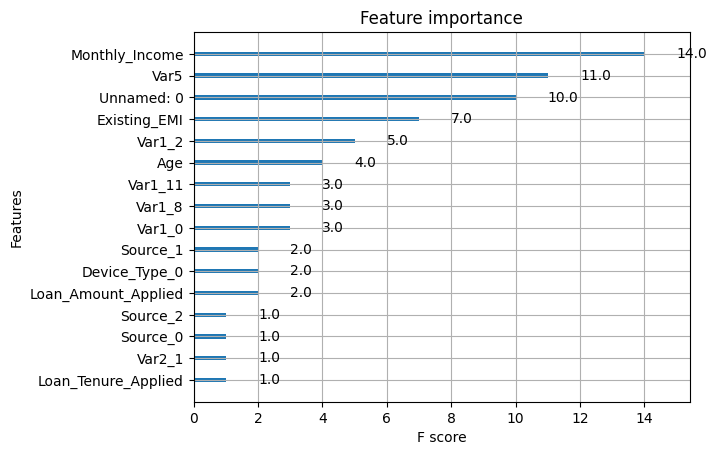

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))
xgb.plot_importance(bst) # умеет изображать важности признаков

Теперь обучу модель с помощью ансамбля LightGBM:

In [ ]:
!pip install lightgbm

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
X_train = pd.read_csv('train_small.csv')
X_test = pd.read_csv('test_small.csv')
y_train = X_train['Disbursed']
X_train = X_train.drop('Disbursed', axis=1)
y_test = X_test['Disbursed']
X_test = X_test.drop('Disbursed', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=100, random_state=241)

Обучение lightgbm

In [ ]:
# Сначала нужно избавиться от всех символов, вспомню регулярные выражения для этого:
# регулярное выражение [^w]+ соответствует одному или более символу, которые не являются буквами, цифрами или подчеркиванием, они будут заменены.
# re.sub - воспроизведет замену
#  w - символ слова (буквы, цифры, подчеркивание)
# + - одно или более вхождений предыдущего символа или группы символов
import re
# Удаление специальных символов из имен признаков
X_train.columns = [re.sub('[^A-Za-z0-9_]+', '', col) for col in X_train.columns] # для признаков X_train
X_test.columns = [re.sub('[^A-Za-z0-9_]+', '', col) for col in X_test.columns] # для признаков X_test

In [ ]:
print('Starting training...')
# train
gbm = lgb.LGBMRegressor(num_leaves=24265,
                        learning_rate=0.15083,
                        n_estimators=48)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1') # метрика оценки качества

Starting training...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1012
[LightGBM] [Info] Number of data points in the train set: 24265, number of used features: 48
[LightGBM] [Info] Start training from score 0.015083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

LGBMRegressor(learning_rate=0.15083, n_estimators=48, num_leaves=24265)

Предсказание и оценка качества

In [ ]:
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_) # когда предскажем на тесте, потом увидем ошибку
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
# feature importances
print('Feature importances:', list(gbm.feature_importances_))

Starting predicting...
The rmse of prediction is: 0.06599679067308348
Feature importances: [11270, 3074, 2256, 1962, 7494, 1396, 2570, 6073, 369, 0, 274, 0, 92, 296, 0, 233, 0, 483, 0, 23, 115, 89, 80, 0, 8, 8, 0, 93, 95, 181, 110, 52, 2, 3, 13, 0, 1, 3, 0, 165, 173, 1, 14, 6, 10, 69, 0, 374, 612, 360]


Можно задать любую метрику качества - надо написать свою функцию.

In [ ]:
# self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False


print('Starting training with custom eval function...')
# train
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=rmsle)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmsle of prediction is:', rmsle(y_test, y_pred)[1])

Starting training with custom eval function...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1012
[LightGBM] [Info] Number of data points in the train set: 24265, number of used features: 48
[LightGBM] [Info] Start training from score 0.015083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

The rmsle of prediction is: 0.059886186976303726

Подбор гиперпараметров:

In [ ]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'n_estimators': [20, 30, 40, 50, 70, 100, 120]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)
print('Best parameters found by grid search are:', gbm.best_params_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 16176, number of used features: 46
[LightGBM] [Info] Start training from score 0.015702
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 16177, number of used features: 47
[LightGBM] [Info] Start training from score 0.014898
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

Best parameters found by grid search are: {'learning_rate': 0.05, 'n_estimators': 30}


Предсказание и оценка:

In [ ]:
pred = gbm.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, pred)

0.0011384060302377834

Теперь сделаю обучение на последнем ансамбле: Catboost.

In [ ]:
!pip install catboost

In [ ]:
import catboost
print(catboost.__version__)
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *

1.2.3


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
X_train = pd.read_csv('train_small.csv')
X_test = pd.read_csv('test_small.csv')
y_train = X_train['Disbursed']
X_train = X_train.drop('Disbursed', axis=1)
y_test = X_test['Disbursed']
X_test = X_test.drop('Disbursed', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=100, random_state=1234)

In [ ]:
cat_features = list(range(0, X_train.shape[1])) # смотрим признаки, возвращает количество столбцов (признаков) в датафрейме.
print(cat_features)
# Теперь признаки будут рассматриваться как категориальные при построении модели. Это может помочь модели правильно обрабатывать данные и использовать их эффективнее в процессе обучения.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [ ]:
# выведу уникальные значения целевой переменной:
# уникальные значений в обучающем наборе
print('Уникальные значения в y_train:', set(y_train))
# Кол-во нулей и единиц в целевой переменной обучающего набора
print('Zero count = {}, One count = {}'.format(len(y_train) - sum(y_train), sum(y_train)))
# уникальные значения целевой переменной в тестовом наборе
print('Уникальные значения в y_test:', set(y_test))
# Кол-во нулей и единиц в целевой переменной тестового набора
print('Zero count = {}, One count = {}'.format(len(y_test) - sum(y_test), sum(y_test)))

Уникальные значения в y_train: {0.0, 1.0}
Zero count = 23899.0, One count = 366.0
Уникальные значения в y_test: {0.0}
Zero count = 100.0, One count = 0.0


In [ ]:
# Проверю, есть ли директорий, для этого можно написать простой код:
import os
directory_path = './train_small.csv'  # путь к директории
if os.path.exists(directory_path):
  print("Директория существует.")
else:
  print("Директория не существует.")

Директория существует.


In [ ]:
import os
directory_path = './test_small.csv'
if os.path.exists(directory_path):
  print("Директория существует.")
else:
  print("Директория не существует.")
# Ну, вроде бы все на месте

Директория существует.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=100, random_state=1234)

Обучение

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=150,          # гиперпараметры
    learning_rate=0.5,
)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 150, 'learning_rate': 0.5}


In [ ]:
# Это так поняла, что это необязательно, я закоментила
# Печать результатов:
#from catboost import CatBoostClassifier
#model = CatBoostClassifier(
 #   iterations=150,
#     verbose=5, - уровень многословности
#)
#model.fit(
 #   X_train, y_train,
  #  eval_set=(X_test, y_test),
  #  verbose = 3
#)

Learning rate set to 0.158839
0:	learn: 0.4214781	test: 0.4259230	best: 0.4259230 (0)	total: 28.4ms	remaining: 4.23s
3:	learn: 0.1266418	test: 0.1316449	best: 0.1316449 (3)	total: 63.1ms	remaining: 2.3s
6:	learn: 0.0839695	test: 0.0940002	best: 0.0940002 (6)	total: 94.7ms	remaining: 1.93s
9:	learn: 0.0727250	test: 0.0848723	best: 0.0848723 (9)	total: 143ms	remaining: 2s
12:	learn: 0.0689847	test: 0.0803851	best: 0.0802251 (11)	total: 222ms	remaining: 2.34s
15:	learn: 0.0664045	test: 0.0766671	best: 0.0766671 (15)	total: 301ms	remaining: 2.52s
18:	learn: 0.0647501	test: 0.0753524	best: 0.0750283 (17)	total: 372ms	remaining: 2.56s
21:	learn: 0.0638036	test: 0.0750316	best: 0.0746279 (20)	total: 465ms	remaining: 2.7s
24:	learn: 0.0626516	test: 0.0724341	best: 0.0724341 (24)	total: 547ms	remaining: 2.74s
27:	learn: 0.0618273	test: 0.0712188	best: 0.0712188 (27)	total: 633ms	remaining: 2.76s
30:	learn: 0.0608291	test: 0.0697640	best: 0.0697640 (30)	total: 721ms	remaining: 2.77s
33:	learn: 0

bestTest = 0.06899841356

bestIteration = 33

Shrink model to first 34 iterations.


In [ ]:
# Метрика качества
from matplotlib import pylab as plt
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=150,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False
)

In [ ]:
# Кол-во деревьев
from catboost import CatBoostClassifier
model = CatBoostClassifier(
  iterations=150, # выберет кол-во деревьев, которые не переобучается, если качесство на тесте растет,значит нужно перестать обучать модель
  random_seed=63,
  learning_rate=0.5,
  use_best_model=False
)
model.fit(
  X_train, y_train,
  eval_set=(X_test, y_test),
  verbose=False
)

In [ ]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 150


In [ ]:
# Кросс-валидация
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 100
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.05

cv_data = cv(
    params = params,
    pool = Pool(X_train, label=y_train),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False
)

Training on fold [0/5]

bestTest = 0.06322170896
bestIteration = 99

Training on fold [1/5]

bestTest = 0.06792089189
bestIteration = 97

Training on fold [2/5]

bestTest = 0.06746905247
bestIteration = 96

Training on fold [3/5]

bestTest = 0.06622206671
bestIteration = 97

Training on fold [4/5]

bestTest = 0.07152784851
bestIteration = 99



bestTest = 0.07152784851

bestIteration = 99



In [ ]:
model_with_early_stop = CatBoostClassifier(
    iterations=100, # сколько деревьев мы обучили на ошибках
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False
)

In [ ]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.5,
)
model.fit(
    X_train, y_train,
    verbose=False
)

Детектор переобучения

In [ ]:
model_with_early_stop = CatBoostClassifier(
    iterations=100, # сколько деревьев мы обучили на ошибках
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False
)

In [ ]:
print(model_with_early_stop.tree_count_)

9


In [ ]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False
)

In [ ]:
print(model_with_early_stop.tree_count_)

7


Выбор порога

In [ ]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=100,
    learning_rate=0.5,
)
model.fit(
    X_train, y_train,
    verbose=False
)

In [ ]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics
eval_pool = Pool(X_test, y_test)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

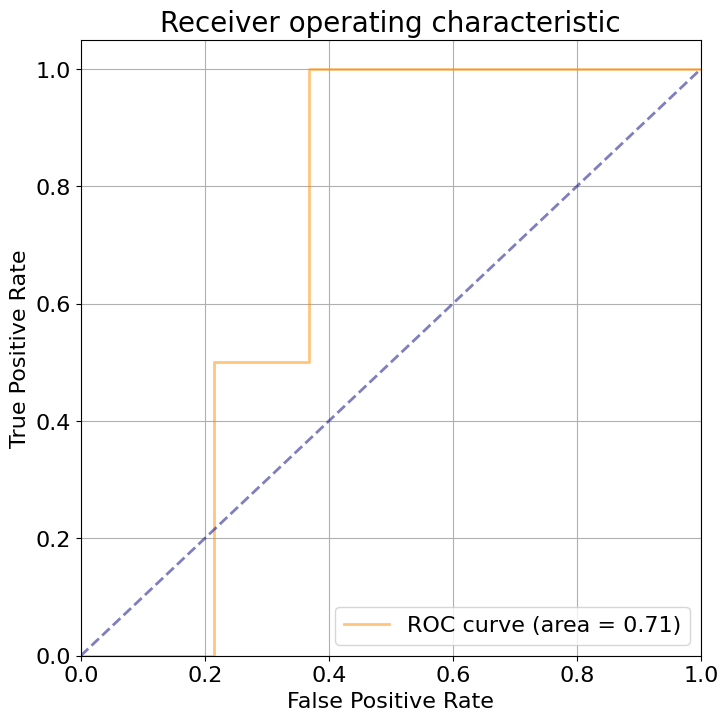

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

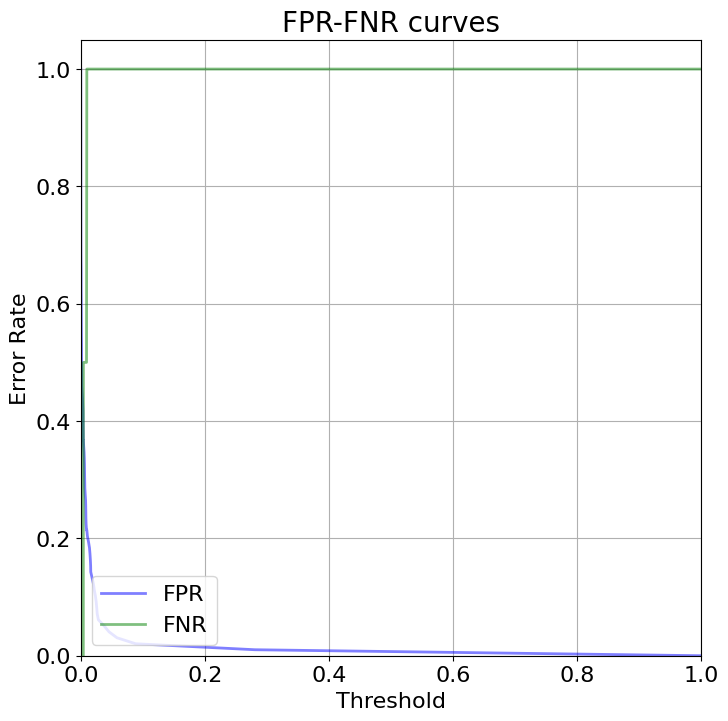

In [ ]:
plt.figure(figsize=(8, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [ ]:
from catboost.utils import select_threshold
print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.004054954234529319
1.0


Предсказание модели

In [ ]:
print(model.predict_proba(X_test))

[[9.9600e-01 3.9952e-03]
 [9.9719e-01 2.8097e-03]
 [9.9915e-01 8.4670e-04]
 [9.5446e-01 4.5535e-02]
 [9.9968e-01 3.2214e-04]
 [9.9990e-01 9.5927e-05]
 [9.9334e-01 6.6563e-03]
 [9.7693e-01 2.3075e-02]
 [9.9845e-01 1.5533e-03]
 [9.8414e-01 1.5861e-02]
 [9.9871e-01 1.2947e-03]
 [9.9859e-01 1.4055e-03]
 [9.9875e-01 1.2535e-03]
 [9.7591e-01 2.4090e-02]
 [9.8378e-01 1.6222e-02]
 [9.9939e-01 6.0920e-04]
 [9.9368e-01 6.3244e-03]
 [9.9661e-01 3.3944e-03]
 [9.9015e-01 9.8460e-03]
 [9.7974e-01 2.0261e-02]
 [9.8537e-01 1.4632e-02]
 [9.7418e-01 2.5820e-02]
 [9.9178e-01 8.2233e-03]
 [9.9974e-01 2.6241e-04]
 [9.9976e-01 2.4317e-04]
 [9.9441e-01 5.5903e-03]
 [9.9986e-01 1.3906e-04]
 [9.9976e-01 2.4207e-04]
 [9.9990e-01 1.0035e-04]
 [9.9989e-01 1.0734e-04]
 [9.8648e-01 1.3515e-02]
 [9.9352e-01 6.4832e-03]
 [9.9935e-01 6.4822e-04]
 [9.9982e-01 1.8406e-04]
 [9.9998e-01 2.0808e-05]
 [9.9877e-01 1.2301e-03]
 [9.9841e-01 1.5874e-03]
 [9.9241e-01 7.5925e-03]
 [9.9032e-01 9.6762e-03]
 [9.9917e-01 8.2762e-04]


In [ ]:
print(model.predict(X_test))

In [ ]:
raw_pred = model.predict(
    data=X_test,
    prediction_type='RawFormulaVal'
)
print(raw_pred)

[ -5.5187  -5.8719  -7.0733  -3.0427  -8.0402  -9.2518  -5.0055  -3.7457
  -6.4658  -4.1279  -6.6482  -6.5659  -6.6806  -3.7016  -4.105   -7.4028
  -5.057   -5.6822  -4.6108  -3.8786  -4.2098  -3.6305  -4.7925  -8.2454
  -8.3215  -5.1811  -8.8805  -8.326   -9.2068  -9.1394  -4.2903  -5.032
  -7.3406  -8.6    -10.7802  -6.6994  -6.4441  -4.873   -4.6284  -7.0961
 -11.5398  -8.5551  -8.7785  -6.5376  -5.5837  -6.3946  -5.9183  -5.6178
  -5.6244  -3.8662 -10.1963  -2.1346  -5.4891  -7.1211  -6.9629  -8.9861
  -5.0925  -9.9914  -8.7099  -3.4896  -9.0064  -3.5782  -9.1051 -11.2794
  -4.4547  -6.8841  -5.5402  -4.8293  -7.7063  -5.2724  -3.0451  -5.4427
  -7.3896 -10.4165  -5.1387  -4.8107  -2.5697  -6.6324  -5.0935  -4.7211
  -8.9133  -9.1629  -8.2651  -3.6377  -8.904   -6.9882  -9.5466  -9.7841
  -0.177   -8.4616  -7.4419  -8.6347  -4.1207 -10.2715  -9.8394  -4.179
  -7.4149  -8.9599  -6.8732  -4.7781]


In [ ]:
from numpy import exp
sigmoid = lambda x: 1 / (1 + exp(-x))
probabilities = sigmoid(raw_pred)
print(probabilities)

[3.9952e-03 2.8097e-03 8.4670e-04 4.5535e-02 3.2214e-04 9.5927e-05
 6.6563e-03 2.3075e-02 1.5533e-03 1.5861e-02 1.2947e-03 1.4055e-03
 1.2535e-03 2.4090e-02 1.6222e-02 6.0920e-04 6.3244e-03 3.3944e-03
 9.8460e-03 2.0261e-02 1.4632e-02 2.5820e-02 8.2233e-03 2.6241e-04
 2.4317e-04 5.5903e-03 1.3906e-04 2.4207e-04 1.0035e-04 1.0734e-04
 1.3515e-02 6.4832e-03 6.4822e-04 1.8406e-04 2.0808e-05 1.2301e-03
 1.5874e-03 7.5925e-03 9.6762e-03 8.2762e-04 9.7349e-06 1.9252e-04
 1.5399e-04 1.4458e-03 3.7444e-03 1.6678e-03 2.6825e-03 3.6193e-03
 3.5958e-03 2.0509e-02 3.7306e-05 1.0578e-01 4.1147e-03 8.0726e-04
 9.4546e-04 1.2512e-04 6.1050e-03 4.5790e-05 1.6491e-04 2.9609e-02
 1.2261e-04 2.7167e-02 1.1108e-04 1.2630e-05 1.1490e-02 1.0229e-03
 3.9102e-03 7.9287e-03 4.4979e-04 5.1049e-03 4.5429e-02 4.3090e-03
 6.1727e-04 2.9935e-05 5.8309e-03 8.0760e-03 7.1113e-02 1.3152e-03
 6.0993e-03 8.8265e-03 1.3457e-04 1.0485e-04 2.5729e-04 2.5638e-02
 1.3583e-04 9.2186e-04 7.1442e-05 5.6339e-05 4.5588e-01 2.1138

# Задание

Решите задачу классификации пассажиров Титаника с помощью любого из ансамблей (или нескольких из них). Если у вас есть наработки по Титанику, используйте их.

Удалось ли улучшить качество с помощью какого-либо из этих алгоритмов?

In [2]:
import pandas as pd
data = pd.read_csv("titanic.csv")
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [ ]:
# Сначала поработую с признаками, так как в 3 семинаре подробно расписала, то просто скопирую то, что уже делала

In [3]:
data.isnull().sum() # пустые значения

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
def add_age(hello):
  Age = hello[0]
  Pclass = hello[1]
  if pd.isnull(Age):
    return int(data[data["Pclass"] == Pclass]["Age"].mean())
  else:
    return Age

In [5]:
data["Age"] = data[["Age", "Pclass"]].apply(add_age,axis=1)
# Так как у нас много пустых значений в cabin, то просто дропнем их
data.drop("Cabin",inplace=True,axis=1)

In [6]:
# Удаляем некоторые строки с нулевыми значениями:
# dropna() удаляет строки, которые содержат хотя бы одно пропущенное значение
data.dropna(inplace=True)
# Так, отлично, данные почистили.
# У нас в датасете есть категориальные признаки, их нужно преобразовать в числовые.

In [7]:
data.head().copy()
# Метод copy() создает глубокую копию этого подмножества данных.
# Глубокое копирование означает создание нового объекта DataFrame с копиями всех данных, что позволяет изменять новый DataFrame, не затрагивая исходный.
# Нам нужно преобразовать из категориальных в числовые пол, name, ticket и embarked

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [ ]:
# Чтобы из категориальных признаков сделать числовые воспользуюсь get_dummies из библиотеки pandas
pd.get_dummies(data["Sex"])
sex = pd.get_dummies(data["Sex"],drop_first=True) #  мужчина = 1, женщина = 0
# аргумент drop_first, когда установлен в True, удалять первый столбец, чтобы избежать мультиколлинеарности.
# также поступим с mbarked and PClass
embarked = pd.get_dummies(data["Embarked"],drop_first=True)
pclass = pd.get_dummies(data["Pclass"],drop_first=True)

In [ ]:
# pd.concat() - позволяет объединить объекты pandas
data = pd.concat([data, pclass, sex, embarked],axis=1)

In [ ]:
# Дропним то, что не очень нужно
data.drop(["PassengerId","Pclass","Name","Sex","Ticket","Embarked"],axis=1,inplace=True)

In [ ]:
X = data.drop("Survived",axis=1)
y = data["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
y.value_counts()

0    549
1    340
Name: Survived, dtype: int64

In [ ]:
X.columns = X.columns.astype(str)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

Посмотрим сначала с логистической регрессией, потом с Xgboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train,pred_train)
test_accuracy = accuracy_score(y_test,pred_test)
print("Training Accuracy: ", train_accuracy)
print("Testing Accuracy: ", test_accuracy)

Training Accuracy:  0.8143459915611815
Testing Accuracy:  0.8202247191011236


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
# Classification report
print("Classification Report:")
print(classification_report(y_test, pred_test))
print(classification_report(y_train, pred_train))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       107
           1       0.84      0.68      0.75        71

    accuracy                           0.82       178
   macro avg       0.83      0.80      0.80       178
weighted avg       0.82      0.82      0.82       178

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       442
           1       0.79      0.70      0.74       269

    accuracy                           0.81       711
   macro avg       0.81      0.79      0.80       711
weighted avg       0.81      0.81      0.81       711



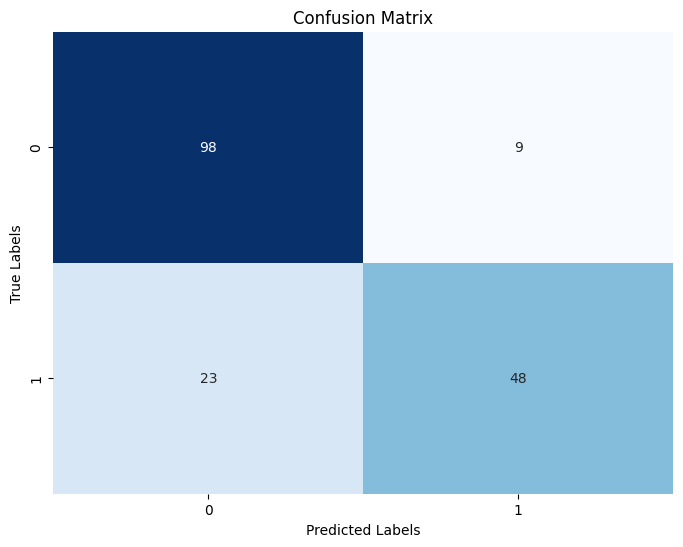

In [ ]:
# Сделаю наглядно
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Теперь попробую через стеккинг

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
data.head().copy()

,Survived,Age,SibSp,Parch,Fare,2,3,male,Q,S
0,0,22.0,1,0,7.2500,0,1,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,1,0,1


In [ ]:
X = data.drop("Survived",axis=1)
y = data["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [ ]:
KNC = KNeighborsClassifier() # инициализирую knn-classifier
NB = GaussianNB() # инициализирую Наивный Байас

In [ ]:
# Приведу все названия признаков к строковому типу.
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
# Сначала потренирую kneighborsclassifier:
model_kNeighborsClassifier = KNC.fit(X_train, y_train)   # тренирую модель
pred_knc = model_kNeighborsClassifier.predict(X_test)   # предсказываю на тесте

In [ ]:
# Оценю модель
acc_knc = accuracy_score(y_test, pred_knc)
print('accuracy score of KNeighbors Classifier is:', acc_knc * 100)

accuracy score of KNeighbors Classifier is: 74.15730337078652


In [ ]:
# Теперь тренирую Наивный Байас:
model_NaiveBayes = NB.fit(X_train, y_train)
pred_nb = model_NaiveBayes.predict(X_test)

In [ ]:
# Оценю Наивный Байас:
acc_nb = accuracy_score(y_test, pred_nb)
print('Accuracy of Naive Bayes Classifier:', acc_nb * 100)

Accuracy of Naive Bayes Classifier: 75.28089887640449


In [ ]:
# Внедрю Stacking Classifier:
lr = LogisticRegression()  # defining meta-classifier
clf_stack = StackingClassifier(classifiers =[KNC, NB], meta_classifier = lr, use_probas = True, use_features_in_secondary = True)

use_probas=True указывает, что классификатор стекирования использует вероятности предсказания в качестве входных данных вместо использования классов предсказаний.

use_features_in_secondary=True указывает, что классификатор стекирования не только принимает прогнозы в качестве входных данных, но и использует функции в наборе данных для прогнозирования на основе новых данных.

In [ ]:
# Тренирую через Stacking Classifier:
model_stack = clf_stack.fit(X_train, y_train)
pred_stack = model_stack.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Оценю через Stacking Classifier:
acc_stack = accuracy_score(y_test, pred_stack)  # evaluating accuracy
print('accuracy score of Stacked model:', acc_stack * 100)

accuracy score of Stacked model: 74.71910112359551


Теперь потренируем датасет на Беггинг (Random Forest)

In [ ]:
data.head().copy()

,Survived,Age,SibSp,Parch,Fare,2,3,male,Q,S
0,0,22.0,1,0,7.2500,0,1,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,1,0,1


In [ ]:
X = data.drop("Survived",axis=1)
y = data["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100, shuffle = True)

In [ ]:
# Приведу все названия признаков к строковому типу.
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)
print('MSE train:', mean_squared_error(y_train, y_pred_train))
print('MSE test:', mean_squared_error(y_test, y_pred_test))

MSE train: 0.008191011988480344
MSE test: 0.21795001146526025


In [ ]:
import numpy as np
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values
_, bias, variance = bias_variance_decomp(dt, X_train_np, y_train_np, X_test_np, y_test_np, loss='mse')


In [ ]:
bias

0.13213677257730158

In [ ]:
variance

0.08451347911097422

In [ ]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
base_tree = DecisionTreeRegressor(random_state=42)
bagging = BaggingRegressor(base_tree, n_estimators=20)
bagging.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(random_state=42),
                 n_estimators=20)

In [ ]:
import numpy as np
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values
_, bias, variance = bias_variance_decomp(dt, X_train_np, y_train_np, X_test_np, y_test_np, loss='mse')

In [ ]:
bias, variance

(0.13165770290074938, 0.08422397598561977)

In [ ]:
# На среднеквадратичной ошибке это отразилось следующим образом
ypred_test = bagging.predict(X_test)
ypred_train = bagging.predict(X_train)
print(mean_squared_error(y_train, ypred_train), mean_squared_error(y_test, ypred_test))

0.028580284393638432 0.13754693214052163


Потренируемся на бустинге (Catboost)

In [48]:
X = data.drop("Survived",axis=1)
y = data["Survived"]

In [49]:
# Чтобы из категориальных признаков сделать числовые воспользуюсь get_dummies из библиотеки pandas
pd.get_dummies(data["Sex"])
sex = pd.get_dummies(data["Sex"],drop_first=True) #  мужчина = 1, женщина = 0
# аргумент drop_first, когда установлен в True, удалять первый столбец, чтобы избежать мультиколлинеарности.
# также поступим с mbarked and PClass
embarked = pd.get_dummies(data["Embarked"],drop_first=True)
pclass = pd.get_dummies(data["Pclass"],drop_first=True)
# тут ошибка, т.к я уже выполнила это, случайно запустила еще раз

KeyError: 'Sex'

In [50]:
# pd.concat() - позволяет объединить объекты pandas
data = pd.concat([data, pclass, sex, embarked],axis=1)

In [51]:
data.head().copy()

,Survived,Age,SibSp,Parch,Fare,2,3,male,Q,S,2,3,male,Q,S
0,0,22.0,1,0,7.2500,0,1,1,0,1,0,1,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,1,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,0,1,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,1,0,1,0,1,1,0,1


In [52]:
# Дропним то, что не очень нужно
data.drop(["PassengerId","Pclass","Name","Sex","Ticket","Embarked"],axis=1,inplace=True)
# случайнр нажала, тут уже выполнено

KeyError: "['PassengerId' 'Pclass' 'Name' 'Sex' 'Ticket' 'Embarked'] not found in axis"

In [53]:
data.head().copy()

,Survived,Age,SibSp,Parch,Fare,2,3,male,Q,S,2,3,male,Q,S
0,0,22.0,1,0,7.2500,0,1,1,0,1,0,1,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0,0,0,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,1,0,1,0,0,1
3,1,35.0,1,0,53.1000,0,0,0,0,1,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,1,1,0,1,0,1,1,0,1


In [54]:
# Посмотрю на баланс классов
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 549, One count = 340


In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=101)

In [18]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.1 MB/s eta 0:00:00


In [57]:
# Обучение (градиентный бустинг)
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


In [58]:
# Напечатаем результаты обучения:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=150,
#     verbose=5,
)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose = 3
)

Learning rate set to 0.047158
0:	learn: 0.6792822	test: 0.6814396	best: 0.6814396 (0)	total: 700us	remaining: 104ms
3:	learn: 0.6416092	test: 0.6517457	best: 0.6517457 (3)	total: 4.21ms	remaining: 154ms
6:	learn: 0.6090224	test: 0.6271540	best: 0.6271540 (6)	total: 8.04ms	remaining: 164ms
9:	learn: 0.5809937	test: 0.6053621	best: 0.6053621 (9)	total: 9.69ms	remaining: 136ms
12:	learn: 0.5589782	test: 0.5878850	best: 0.5878850 (12)	total: 12.9ms	remaining: 136ms
15:	learn: 0.5369785	test: 0.5702624	best: 0.5702624 (15)	total: 21.9ms	remaining: 183ms
18:	learn: 0.5197519	test: 0.5575242	best: 0.5575242 (18)	total: 23.8ms	remaining: 164ms
21:	learn: 0.5041663	test: 0.5461250	best: 0.5461250 (21)	total: 26.8ms	remaining: 156ms
24:	learn: 0.4893764	test: 0.5360563	best: 0.5360563 (24)	total: 29.9ms	remaining: 149ms
27:	learn: 0.4788481	test: 0.5291421	best: 0.5291421 (27)	total: 31.2ms	remaining: 136ms
30:	learn: 0.4659952	test: 0.5199996	best: 0.5199996 (30)	total: 32.4ms	remaining: 124ms


bestTest = 0.4607111467

bestIteration = 144

Shrink model to first 145 iterations.


In [63]:
#метрика на валидационном наборе данных
from catboost import Pool, cv
eval_metrics = model.eval_metrics(Pool(X_test, y_test), ['AUC', 'Accuracy'])

In [67]:
print("AUC on validation set: {:.2f}".format(eval_metrics['AUC'][-1]))
print("Accuracy on validation set: {:.2f}".format(eval_metrics['Accuracy'][-1]))

AUC on validation set: 0.84
Accuracy on validation set: 0.79


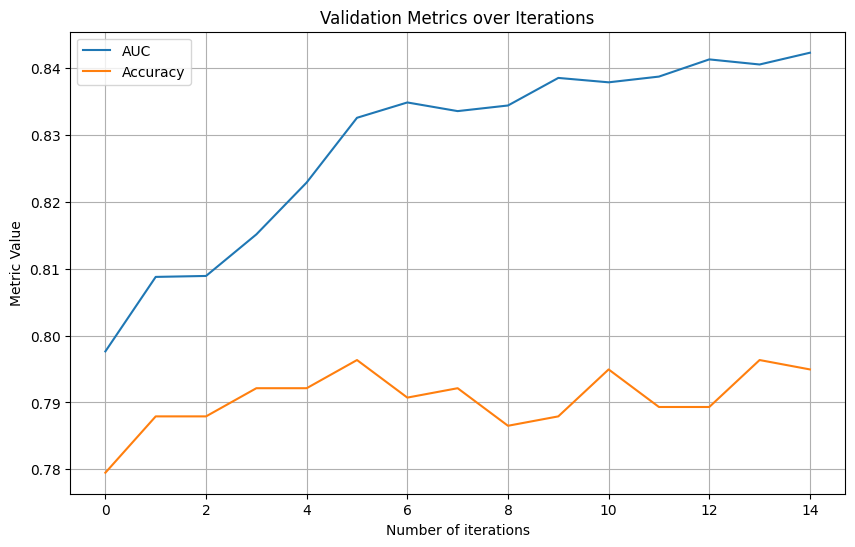

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(eval_metrics['AUC'], label='AUC')
plt.plot(eval_metrics['Accuracy'], label='Accuracy')
plt.xlabel('Number of iterations')
plt.ylabel('Metric Value')
plt.title('Validation Metrics over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
# Наилучшее количество деревьев
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False
)

In [70]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 15


In [72]:
# Кросс-валидация
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 15
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False
)

Training on fold [0/5]

bestTest = 0.4587648747
bestIteration = 5

Training on fold [1/5]

bestTest = 0.4521115388
bestIteration = 4

Training on fold [2/5]

bestTest = 0.4117613605
bestIteration = 12

Training on fold [3/5]

bestTest = 0.3531659574
bestIteration = 12

Training on fold [4/5]

bestTest = 0.4135229959
bestIteration = 11



bestTest = 0.4135229959

bestIteration = 11

In [73]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.501141,0.017919,0.490340,0.019126,0.825643,0.028452
1,1,0.453266,0.027632,0.420269,0.012628,0.848407,0.023771
2,2,0.446837,0.031004,0.409071,0.011687,0.848618,0.022968
3,3,0.436774,0.033429,0.389521,0.011209,0.855247,0.020913
4,4,0.434929,0.032335,0.376415,0.011027,0.858452,0.020245


In [77]:
import numpy as np
from catboost import cv, Pool

cv_data = cv(
    params=params,
    pool=Pool(X, label=y),
    fold_count=5,
    inverted=False,
    shuffle=True,
    partition_random_seed=0,
    stratified=True,
    verbose=False
)
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Training on fold [0/5]

bestTest = 0.4790709253
bestIteration = 3

Training on fold [1/5]

bestTest = 0.4636883174
bestIteration = 4

Training on fold [2/5]

bestTest = 0.3677516437
bestIteration = 9

Training on fold [3/5]

bestTest = 0.4070215066
bestIteration = 4

Training on fold [4/5]

bestTest = 0.4288486745
bestIteration = 7

Best validation Logloss score, stratified: 0.4415±0.0497 on step 5


bestTest = 0.4288486745

bestIteration = 7

Best validation Logloss score, stratified: 0.4415±0.0497 on step 5